In [1]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Convert It to TFLite

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [2]:
# TensorFlow
import tensorflow as tf

# TensorFlow Datsets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from os import getcwd
from absl import logging
logging.set_verbosity(logging.ERROR)

print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.12.0
• GPU Device Found.


# Download Fashion MNIST Dataset

We will use TensorFlow Datasets to load the Fashion MNIST dataset. 

In [3]:
filePath = f"{getcwd()}/../tmp2/"

(train_examples, validation_examples, test_examples), info = tfds.load('fashion_mnist', 
                                                                        data_dir=filePath,
                                                                        with_info=True, 
                                                                        as_supervised=True, 
                                                                        split=['train[:80%]',
                                                                               'train[80%:90%]',
                                                                               'train[90%:]'])

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dataset fashion_mnist downloaded and prepared to /content/../tmp2/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


The class names are not included with the dataset, so we will specify them here.

In [4]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [6]:
# The images in the dataset are 28 by 28 pixels.
IMG_SIZE = 28

# Preprocessing Data

## Preprocess


In [7]:
# EXERCISE: Write a function to normalize the images.
# UNQ_C1
# GRADED FUNCTION: format_example

def format_example(image, label):
    # Cast image to float32
    image = tf.cast(image, tf.float32)
        
    # Normalize the image in the range [0, 1]
    image = image/255.0
    
    return image, label

In [8]:
# Specify the batch size
BATCH_SIZE = 256

## Create Datasets From Images and Labels

In [9]:
# Create Datasets
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example)
test_batches = test_examples.map(format_example).batch(1)

# Building the Model

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
```

In [10]:
# EXERCISE: Build and compile the model shown in the previous cell.
# UNQ_C2
# GRADED CODE: model
model = tf.keras.Sequential([
    # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,
    tf.keras.layers.Conv2D(input_shape = (28, 28, 1), kernel_size = (3, 3), filters = 16, activation = 'relu'),
      
    tf.keras.layers.MaxPooling2D(),
      
    # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
    tf.keras.layers.Conv2D(kernel_size = (3, 3), filters = 32, activation = 'relu'),
      
    # Flatten the output layer to 1 dimension
    tf.keras.layers.Flatten(),
      
    # Add a fully connected layer with 64 hidden units and ReLU activation
    tf.keras.layers.Dense(64, activation = 'relu'),
      
    # Attach a final softmax classification head
    tf.keras.layers.Dense(10, activation = 'softmax')])

# Set the appropriate loss function and use accuracy as your metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train

In [11]:
# UNQ_C3
history = model.fit(train_batches, epochs=10, validation_data=validation_batches)

Epoch 1/10
188/188 [==============================] - 18s 22ms/step - loss: 0.6126 - accuracy: 0.7873 - val_loss: 0.3998 - val_accuracy: 0.8582
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.3882 - accuracy: 0.8619 - val_loss: 0.3496 - val_accuracy: 0.8713
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.3374 - accuracy: 0.8798 - val_loss: 0.3111 - val_accuracy: 0.8890
Epoch 4/10
188/188 [==============================] - 1s 5ms/step - loss: 0.3024 - accuracy: 0.8922 - val_loss: 0.2952 - val_accuracy: 0.8905
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.2848 - accuracy: 0.8972 - val_loss: 0.2784 - val_accuracy: 0.8992
Epoch 6/10
188/188 [==============================] - 1s 7ms/step - loss: 0.2634 - accuracy: 0.9052 - val_loss: 0.2896 - val_accuracy: 0.8938
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 0.2486 - accuracy: 0.9111 - val_loss: 0.2648 - val_accuracy: 0.9027
Epoc

# Exporting to TFLite

You will now save the model to TFLite. We should note, that you will probably see some warning messages when running the code below. These warnings have to do with software updates and should not cause any errors or prevent your code from running. 

In [12]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
# UNQ_C4
# GRADED CODE: save_model

export_dir = 'saved_model/1'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

In [13]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [14]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter
# UNQ_C5
# GRADED CODE: save_model

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [15]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

259728

# Test the Model with TFLite Interpreter 

In [16]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [17]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

In [18]:
# Utilities functions for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

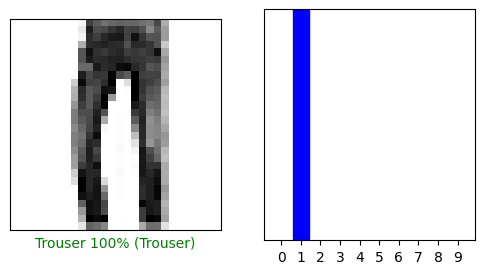

In [19]:
# Visualize the outputs

# Select index of image to display. Minimum index value is 1 and max index value is 50. 
index = 49 

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(index, predictions, test_labels)
plt.show()

# Click the Submit Assignment Button Above

You should now click the Submit Assignment button above to submit your notebook for grading. Once you have submitted your assignment, you can continue with the optinal section below. 

## If you are done, please **don't forget to run the last two cells of this notebook** to save your work and close the Notebook to free up resources for your fellow learners. 

# Prepare the Test Images for Download (Optional)

In [20]:
!mkdir -p test_images

In [21]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [22]:
!ls test_images

'ankle boot_10.jpg'   coat_40.jpg       sandal_19.jpg	 sneaker_43.jpg
'ankle boot_32.jpg'   coat_46.jpg       sandal_2.jpg	 trouser_20.jpg
'ankle boot_4.jpg'    coat_48.jpg       sandal_39.jpg	 trouser_22.jpg
 bag_16.jpg	      dress_12.jpg      shirt_27.jpg	 trouser_35.jpg
 bag_17.jpg	      dress_29.jpg      shirt_33.jpg	 trouser_49.jpg
 bag_23.jpg	      dress_37.jpg      shirt_5.jpg	 t-shirt_top_15.jpg
 bag_34.jpg	      dress_45.jpg      sneaker_13.jpg	 t-shirt_top_18.jpg
 bag_36.jpg	      dress_6.jpg       sneaker_24.jpg	 t-shirt_top_1.jpg
 bag_3.jpg	      pullover_28.jpg   sneaker_25.jpg	 t-shirt_top_21.jpg
 bag_7.jpg	      pullover_44.jpg   sneaker_26.jpg	 t-shirt_top_47.jpg
 coat_11.jpg	      pullover_9.jpg    sneaker_38.jpg	 t-shirt_top_8.jpg
 coat_30.jpg	      sandal_0.jpg      sneaker_41.jpg
 coat_31.jpg	      sandal_14.jpg     sneaker_42.jpg


In [23]:
!tar --create --file=fmnist_test_images.tar test_images

In [24]:
!ls

fmnist_test_images.tar	model.tflite  saved_model
labels.txt		sample_data   test_images


# When you're done/would like to take a break, please run the two cells below to save your work and close the Notebook. This frees up resources for your fellow learners.

In [25]:
%%javascript
<!-- Save the notebook -->
IPython.notebook.save_checkpoint();

<IPython.core.display.Javascript object>

In [26]:
%%javascript
<!-- Shutdown and close the notebook -->
window.onbeforeunload = null
window.close();
IPython.notebook.session.delete();

<IPython.core.display.Javascript object>